# CS 583 -- Fall, 2021 -- Homework 3


### Due date: Due Friday, November 19th, @ midnight in GradeScope with 1 day grace period


### General Instructions

Please complete this notebook by filling in solutions where indicated. Be sure to "Run All" from the Cell menu before submitting. 

 

In [1]:
# General useful imports
import numpy as np
import matplotlib.pyplot as plt
import librosa 
import librosa.display
from IPython.display import Audio

from scipy import signal

from scipy.signal import find_peaks, windows

%matplotlib inline

# Basic audio parameters

SR            = 22050                  #  sample rate default for Librosa

# Utility functions

# Round to 4 decimal places

def round4(x):
    return np.around(x,4)   


In [2]:
def makeSignal(S=[(440,1,0)], A = None, duration=1.0,sr=SR):
    X = np.zeros(int(sr*duration)) 
    T = np.arange(int(sr*duration))
    for (f,amp,phi) in S:         
        X +=  amp * np.sin( 2 * np.pi * f * T / sr + phi )
    X / max(X)         # normalize to amplitude 1.0
    if(A == None):
        return  X       
    else:
        return  A * X   

In [3]:
# get signal array and sample rate from a local audio file, will resample to 
#     default SR of 22050

import soundfile as sf
import io
import warnings

from six.moves.urllib.request import urlopen

def readSignal(name,sr=None):    
    if(name[:5] == 'https'):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X, fileSR = sf.read(io.BytesIO(urlopen(name).read()))           
    else:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X, fileSR = librosa.load(name)
    if((sr == None) or (fileSR == sr)):
        return X
    else:
        return librosa.resample(X,fileSR,SR) 

# write signal array out to a file in your local directory (or to complete path name)

def writeSignal(name,data,sr=SR):
    sf.write(name,data,sr)
    

In [4]:
# Display 


def displaySignal(X, sr=SR, title='Signal Window for X',x_units = "Seconds", figsize=(14,6),gridlines=False): 
    
    if(x_units == "Seconds"):
        T = np.arange(0, len(X)/sr, 1/sr)
    elif(x_units == "Milliseconds"):
        T = np.arange(0, 1000*len(X)/sr, 1000/sr)
    elif(x_units == "Samples"):
        T = np.arange(len(X))

    plt.figure(figsize=figsize)   # Set x and y dimensions of window: may need to redo for your display
    plt.title(title, fontsize=14, fontweight='bold')
    if(x_units=="Samples"):
        plt.xlabel("Sample Number")
    else:
        plt.xlabel(x_units)
    plt.ylabel("Amplitude")
    plt.ylim([-1.1,1.1])
    plt.plot([0,T[-1]],[0,0],color='black')      # draw the 0 line in black
    plt.plot(T,X)                    
    plt.grid(gridlines)                     # if you want dotted grid lines
    plt.show()
    
# test

# f = 10
# X = makeSignal([(10,1,0)])
# displaySignal(X,gridlines=True)

# displaySignal(X,x_units="Samples")

# displaySignal(X,x_units="Milliseconds")


In [5]:
# display the waveform using librosa

def displaySignal2(x,sr=SR,title='Signal X',):
    plt.figure(figsize=(12,6))
    plt.title(title)
    plt.ylim([-1.1,1.1])           # if you want the full range -1 .. 1, else will adapt to signal
    plt.plot([0,librosa.get_duration(x)],[0,0],linewidth=1,color='k') # if you want a 0 line
    #plt.grid()                    # if you want gridlines
    librosa.display.waveshow(x,sr=sr)
    plt.show()
    
# X = readSignal(k + "trumpet_A4_1_forte_normal.wav")

# displaySignal(X)

In [6]:
def realFFT(X):
    return 2*abs(np.fft.rfft(X))/len(X) 

### Problem One: Peak Picking

As with frequency detection, a fundamental part of the process of detecting onsets is
to pick the appropriate peaks once candidate onsets have been detected.  

Unfortunately, our naive strategy from HW 02 is no longer sufficient, and we will use
the function `find_peak` from the `scipy.signal` library, which you can read about here:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

(There is a nice example of peak picking in an electrocardiogram there which you should look over.)



Part of the *art* of audio processing is figuring out the right hyper-parameters for the peaking-picking
algorithm (we will see this throughout the MIR part of the course).  

Three of the most useful are

1. **height** -- minimum height of a peak (we called this the *threshold* in hw02);          
2. **distance** -- minimum distance between peaks (to avoid multiple peaks at same onset);
3. **prominence** -- relative height compared with nearby peaks; from Wikipedia: "The prominence of a peak may be defined as the least drop in height necessary in order to get from the summit to any higher terrain." 

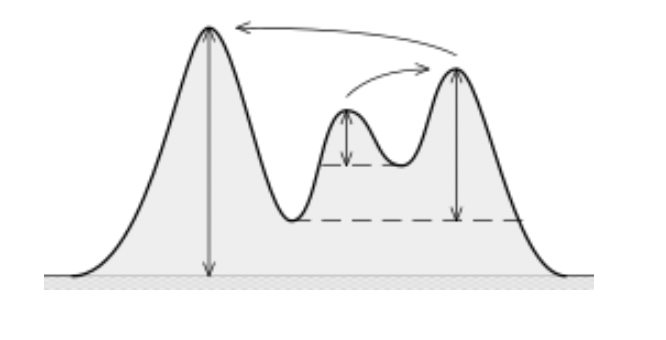

The values assigned for these are the units used on the y-axis, or `None`; for a peak to be selected it must satisfy all non-None parameters. You can also specify a min-max range of values (see the documentation for more details).  

Here is the example from lecture (I found it on Stack Overflow):

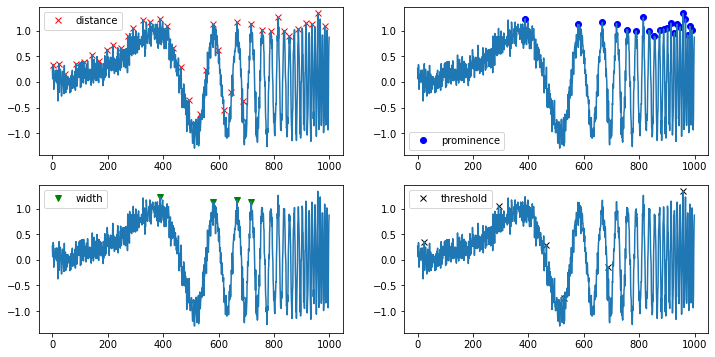

In [24]:
# I used a (noisy) frequency-varying sinusoid on purpose because it shows many difficulties. 
# We can see that the width parameter is not very useful here because if you set a minimum 
# width too high, then it won't be able to track very close peaks in the high frequency part. 
# If you set width too low, you would have many unwanted peaks in the left part of the signal. 
# Same problem with distance. threshold only compares with the direct neighbours, which is not 
# useful here. prominence is the one that gives the best solution. Note that you can combine 
# many of these parameters!

np.random.seed(0)
x1 = np.sin(2*np.pi*(2**np.linspace(2,10,1000))*np.arange(1000)/48000) + np.random.normal(0, 1, 1000) * 0.15

peaks, _ = find_peaks(x1, distance=20)
peaks2, _ = find_peaks(x1, prominence=1)      # BEST!
peaks3, _ = find_peaks(x1, width=20)
peaks4, _ = find_peaks(x1, threshold=0.4)     # Required vertical distance to its direct neighbouring samples, pretty useless
plt.figure(figsize=(12,6))
plt.subplot(2, 2, 1)
plt.plot(peaks, x1[peaks], "xr"); plt.plot(x1); plt.legend(['distance'])
plt.subplot(2, 2, 2)
plt.plot(peaks2, x1[peaks2], "ob"); plt.plot(x1); plt.legend(['prominence'])
plt.subplot(2, 2, 3)
plt.plot(peaks3, x1[peaks3], "vg"); plt.plot(x1); plt.legend(['width'])
plt.subplot(2, 2, 4)
plt.plot(peaks4, x1[peaks4], "xk"); plt.plot(x1); plt.legend(['threshold'])
plt.show()

#### Part (A)

We are going to simply explore these three parameters so that you are comfortable with solving problems using peak picking. 

First, let us explore the `height` parameter (called *threshold* in the last homework). 

For the following, replace the `None` for the height parameter with a value which will generate only the topmost 5 peaks:

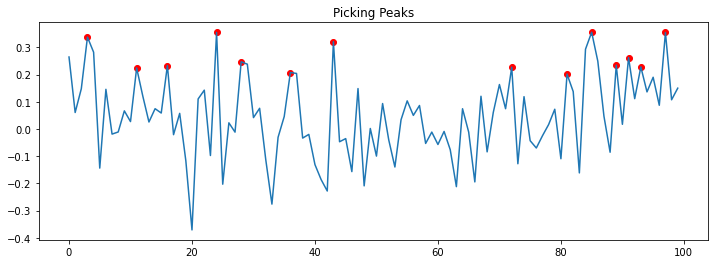

In [25]:
x1a = x1[:100]
peaks,_ = find_peaks(x1a,height=0.2,prominence=None,distance=None)   

plt.figure(figsize=(12,4))
plt.title("Picking Peaks")
plt.plot(peaks, x1a[peaks], "or")
plt.plot(x1a)
plt.show()

#### Part (B)

Next, replace the `None` for the height parameter with a range `[lo,hi]` which will generate the 5 peaks *closest* to 0.0 (hint: make the range symmetric around 0.0):

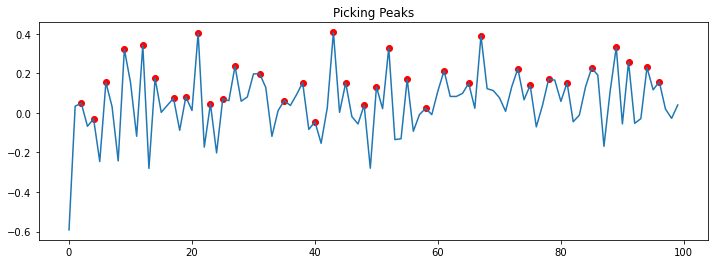

In [9]:

peaks,_ = find_peaks(x1a,height=None,prominence=None,distance=None)   

plt.figure(figsize=(12,4))
plt.title("Picking Peaks")
plt.plot(peaks, x1a[peaks], "or")
plt.plot(x1a)
plt.show()

#### Part (C)

Next, the distance parameter will reject any peak that is too close to the previous peak. 

For the following, provide parameters for the `height` and `distance` parameters which 
are within 0.1 of 0, and which are at least 10 units apart:

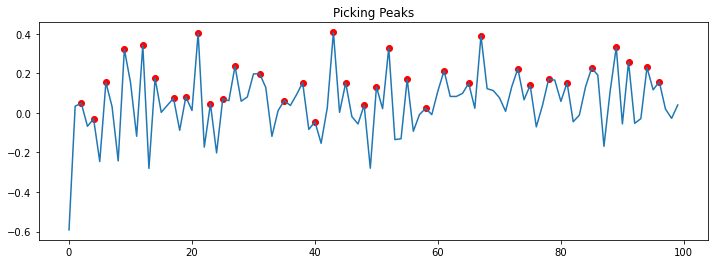

In [10]:

peaks,_ = find_peaks(x1a,height=None,prominence=None,distance=None)   

plt.figure(figsize=(12,4))
plt.title("Picking Peaks")
plt.plot(peaks, x1a[peaks], "or")
plt.plot(x1a)
plt.show()

#### Part (D)

The `prominence` parameter appears to be the most useful for general audio applications. 

Provide a value for `prominence` which will select the best 5 peaks (from the point of view of prominence):

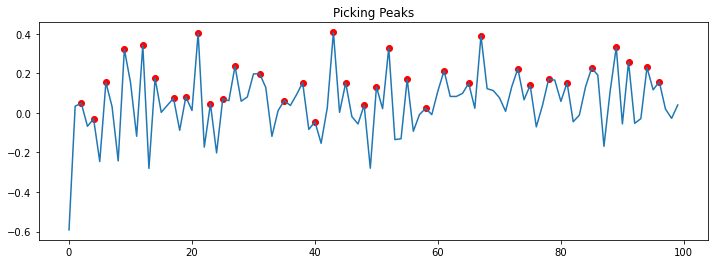

In [11]:

peaks,_ = find_peaks(x1a,height=None,prominence=None,distance=None)   

plt.figure(figsize=(12,4))
plt.title("Picking Peaks")
plt.plot(peaks, x1a[peaks], "or")
plt.plot(x1a)
plt.show()

#### Part (E)

Find the top 5 peaks (from the point of view of prominence) which are of height between 0.1 and 0.3 and no closer than 10 units.  


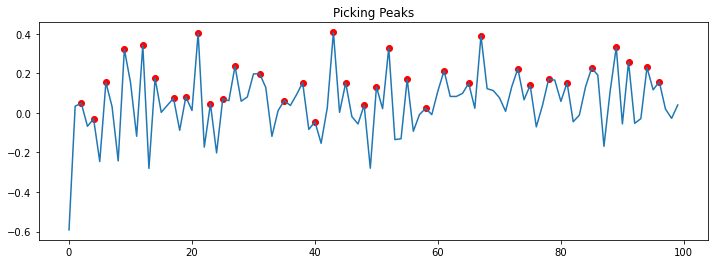

In [12]:

peaks,_ = find_peaks(x1a,height=None,prominence=None,distance=None)   

plt.figure(figsize=(12,4))
plt.title("Picking Peaks")
plt.plot(peaks, x1a[peaks], "or")
plt.plot(x1a)
plt.show()

### Onset Detection

There are several ways to approach the subject of *onset detection*, basically looking at different sliding windows and determining when changes occur in various attributes such as amplitude or spectra.  


## Problem Two

First we need to create an amplitude-based onset detector, as demonstrated in lecture. 

Complete the following template, with detailed instructions in each place where you need to write code. 

In [41]:
a = np.array([.1, .2, -0.1, 0.22])


np.mean(a ** 2)



0.027100000000000003

In [13]:
# Amplitude-based onset detection

def AmplitudeBasedOnsets(X,
                         window_size=512,     # width of the analysis window, in samples
                         hop_length=128,      # how far to move the window each time (could also called "hop_length")
                         scale=10,            # scaling factor for log transformation
                                              # Peak picking parameters:  
                         height=None,           # minimum height (we called this threshold in hw02)          
                         prominence=None,       # relative height compared with nearby peaks; see lecture for details
                         distance=None,         # minimum distance between peaks (to avoid multiple peaks at same onset)
                         displayAll=False):   # To print out displays of various signals
    
    
    # Normalize amplitude of X so maximum is 1.0
    
    # your code here   
    
    X = X / np.max(X)
    
    # Create the energy envelope by using the sliding window technique to calculate the energy
    # in each window and storing it in a numpy array X_energy. The energy in a window is the mean 
    # of the squared samples. 
    
    # Hints:  Easiest is probably to create empty list and append the energy measurements in 
    # a for loop, then convert to numpy array at end. You should end up with (N // hop_length) - 1
    # values in the array; don't worry about it if the last window is not full size. 
    # Could also do with a list comprehension. 

    # your code here 
    

    
    
    # The energy in a window is the mean of the squared samples

    X_energy = []          # your code here   
    

    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("X Energy Signal")
        plt.plot(X_energy)
        plt.show()

    # take the log with scaling factor:   np.log(1.0 + scale * X_energy)
    # if scale = None, do nothing

    if(scale == None):
        X_energy_log = X_energy     # your code here 
    else:
        X_energy_log = 
    
    

    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Log X Energy Signal with scale factor "+str(scale))
        plt.plot(X_energy_log)
        plt.show()

    # Calculate the novelty function (first difference) using np.diff(...)
    # Watch out:  np.diff(...) changes the array IN PLACE, so make a copy beforehand if you want
    # (debugging is easier if you have all the successive arrays)
    
    # Optional: add 0 at beginning before taking difference so have exactly the same number of values as X_energy
    
    # your code here   

    X_energy_novelty = []      # your code here   
    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("X Energy Novelty")
        plt.plot(X_energy_novelty)
        plt.show()
        
    # Now perform half-wave recification by setting all values < 0 to 0. 
    # Hint: I provided this in problem 5.

    X_energy_novelty_rectified = []    
    
    # Now normalize the novelty so the maximum is 1.0; this will make choosing hyper-parameters more consistent
    
    # your code here
    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Rectified X Energy Novelty")
        plt.plot(X_energy_novelty_rectified)
        plt.show()

    # peak picking using parameters from the argument list: height, prominence, and distance

    peaks,_ = find_peaks(X_energy_novelty_rectified,height=height,prominence=prominence,distance=distance)   
    
    plt.figure(figsize=(12,4))
    plt.title("Picking Peaks")
    plt.plot(peaks, X_energy_novelty_rectified[peaks], "or")
    plt.plot(X_energy_novelty_rectified)
    plt.show()
    
    # peaks is a list of indices in X_energy_novelty_rectified where peaks were identified; you need to
    # convert from indices in X_energy_novelty_rectified (one value for each sliding window) to sample numbers in X.
    # Important: calculate the location from the MIDDLE of the window.  
    
    onsets = []   # your code here   

    plt.figure(figsize=(12,4))
    plt.title("Signal with Onsets")
    plt.plot(X)  
    for k in range(len(onsets)):
        plt.plot([onsets[k],onsets[k]],[-1,1],color='r')    
    plt.show()
    
    clicks = librosa.clicks(times=onsets/SR, sr=SR, hop_length=hop_length, length=len(X))
    
    return (onsets,clicks)





In [ ]:
W = window numbers

S = sample numbers

T = time (in seconds)

W = 2

S = W*hop_length

T = S / SR



### Test your code!

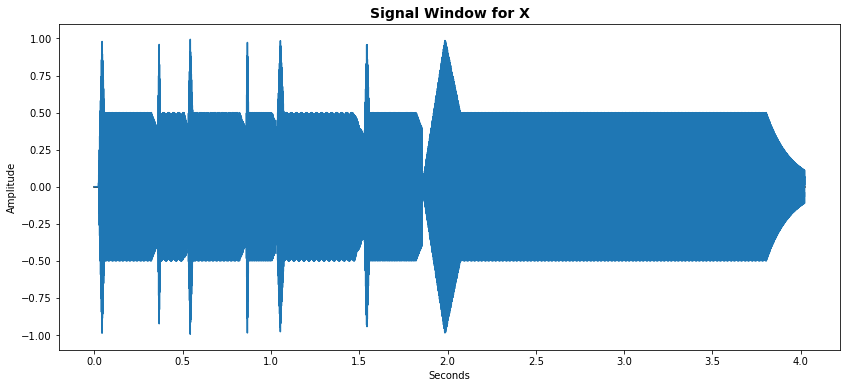

In [14]:
X1 = readSignal("https://www.cs.bu.edu/fac/snyder/cs583/AudioSamples/thelick.wav") 
X1 = np.concatenate([np.zeros(500),X1])           # add silence to beginning or else can't find first onset
displaySignal(X1)
Audio(X1,rate=SR)

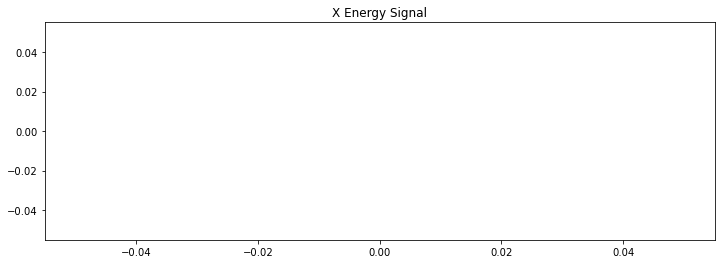

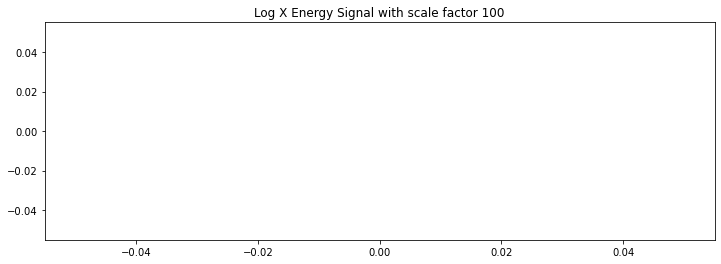

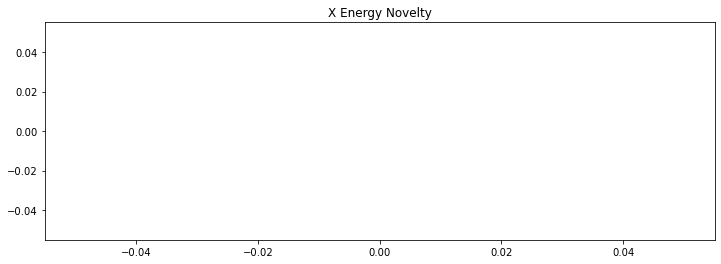

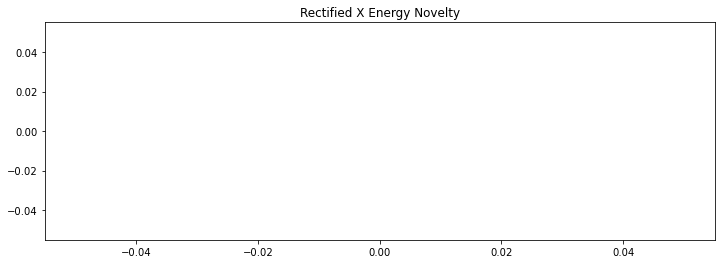

TypeError: only integer scalar arrays can be converted to a scalar index

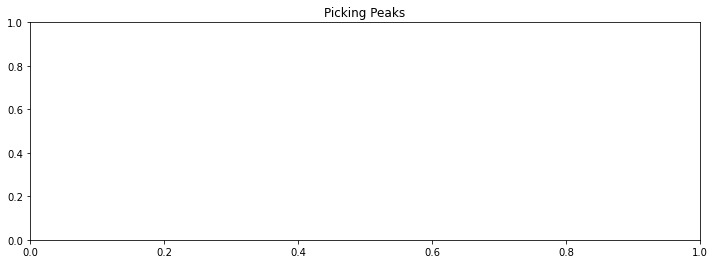

In [15]:
(onsets1,clicks1) = AmplitudeBasedOnsets(X1,
                                         window_size=512,
                                         hop_length=128,
                                         scale=100,
                                         prominence=0.2,
                                         displayAll=True
                                        )

plt.figure(figsize=(12,6))
plt.title("The Lick with Clicks")
plt.plot(X1)
plt.plot(clicks1,color='r')
plt.show()

Audio([X1,clicks1],rate=SR)

## Problem Three: Hyper-parameter tuning

For the most part, the process of onset detection is the process of exploring
the settings for the `find_peak` algorithm (we will explore window size and hop length
in the next problem). 

For the following signals, find the best values for the parameters `height`, `prominence`, and `distance`
for determining the onsets, at least according to your ears. In the last part, you will comment on what
you have learned. 

Hint: You do not need to use every parameter every time. I would suggest starting with prominence and then adding other parameters as needed. You may also want to play around with the `scale` parameter, which should emphasize lower-amplitude parts of the signal. 

#### Part (A)

In [ ]:
X3a = readSignal("https://www.cs.bu.edu/fac/snyder/cs583/AudioSamples/AnotherOneBitesTheDust.wav")
X3a = X3a[:SR*10]      # just select the first 10 seconds
displaySignal(X3a)
Audio(X3a,rate=SR)

In [ ]:
(onsets3a,clicks3a) = AmplitudeBasedOnsets(X3a,
                                         window_size=513,
                                         hop_length=256,
                                         scale=None,
                                         prominence=None,
                                         distance=None,
                                         displayAll=True
                                        )

plt.figure(figsize=(13,6))
plt.title("Another One Bites The Dust (Queen)")
plt.plot(X3a)
plt.plot(clicks3a,color='r')
plt.show()

Audio([X3a,clicks3a],rate=SR)

#### Part (B)

In [ ]:
X3b,_ = librosa.load(librosa.ex('trumpet'))

X3b = np.concatenate([np.zeros(11025),X3b])     # add silence at end so can find first onset

displaySignal(X3b)
Audio(X3b,rate=SR)

In [ ]:
# your code here



#### Part (C)

In [ ]:
X3c,_ = librosa.load(librosa.ex('choice'))

X3c = X3c[:SR*10]

displaySignal(X3c)
Audio(X3c,rate=SR)

In [ ]:
# Your code here


#### Part (D)

In [ ]:
X3d = readSignal("https://www.cs.bu.edu/fac/snyder/cs583/AudioSamples/SoWhat.KindOfBlue_01.wav")


displaySignal(X3d)
Audio(X3d,rate=SR)

In [ ]:
# Your code here


#### Part (E)

In [ ]:
X3e = readSignal("https://www.cs.bu.edu/fac/snyder/cs583/AudioSamples/Tigran_Hamasyan_01.wav")


displaySignal(X3e)
Audio(X3e,rate=SR)

In [ ]:
# Your code here


#### Part (F)

Explain in a paragraph what you discovered about the role of the various parameters. 

1. I found the prominence to be the most useful, is this what you also think?

2. Did height play a role in any of the choices you made?  

3. How about distance?

4. How about scale?

## Problem Four: Exploring the role of window size and hop length

Now we will explore how the window size and the hop length (called *skip* in previous homeworks)
affect the process of finding onsets. Since the window size determines the temporal resolution of
the analysis, we would expect that shorter windows provide better onset measurements. 

We will use the Karplus-Strong C major scale; each onset occurs at precisely half-second intervals;
since we know *exactly* where the onsets are, we can evaluate how accurate our measurements are

In [ ]:
# First test:  Karplus-Strong C major scale, with each note at 0.5 sec intervals

X4 = readSignal("https://www.cs.bu.edu/fac/snyder/cs583/AudioSamples/KS.guitar.C.scale.wav") 

displaySignal(X4)
Audio(X4,rate=SR)

#### Part (A)

For this first part, just find parameters that work for this example (should be easy after doing the previous problem). Use a window size of 512 and hop length of 256, as in the previous problem. 

In [ ]:

(onsets4,clicks4) = AmplitudeBasedOnsets(X4,
                                         window_size=513,
                                         hop_length=256,
                                         scale=None,
                                         prominence=None,
                                         distance=None,
                                         displayAll=True
                                        )   

plt.figure(figsize=(12,6))
plt.plot(X4)
plt.plot(clicks4,color='r')
plt.show()

Audio([X4,clicks4],rate=SR)    


#### Part (B)

Now we will determine the accuracy of the measurements. There are several steps:

1. You must find the actual time in seconds for each of your onsets, using the return value `onsets4` in the first part of the pair returned by `AmplitudeBasedOnsets`. This is a simple calculation using the sample rate. 

2. The *ground truth* for the onsets is that they occur precisely every 0.5 seconds.  Compare your timings found in the previous step, and calculate the absolute value of the errors for each measurement. 

3. Report your accuracy as the *mean absolute error*.  

In [ ]:
# your code here

#### Part (C)

Now we would expect that if we make the window length and/or the hop length shorter, we would increase
the accuracy of the measurement.

Perform an experiment to test this thesis, and report on what you discover, and comment in particular
on the following:

1. Did it matter which of window length or hop length you changed? Which was the most important, or where they both important, perhaps in different ways?

2. Was there a limit to how short you could make one or both of these and get good results?  

3. Assuming that you might potentially have to change the other hyper-parameters, what values (for all the parameters) gave you the best accuracy, as measured against the ground truth values?

As always, SHOW ALL WORK. 

#### Part (D)

Pick one of the examples from the previous problem, and find the onsets using the "best" parameters determined from Part (C). If there are issues (perhaps the "best" does not work for a different sample), try adjusting
all the parameters to achieve the best results. You don't have "ground truth" to work from, but do your best. 

## Onset Detection using Spectrograms

Amplitude-based methods are limited because they ONLY use one dimension
of the signal, its energy in the sliding windows. More sophisticated
algorithms use the FFT and determine the *novelty* measure between the spectrum of the $n^{th}$ window and the previous window using a variety of distance metrics. We will use the following notations:
$$X(n)\ =\ \text{the spectrum of the $n^{th}$ window}$$ 

$$X(k,n)\ =\ \text{the complex value of the $k^{th}$ frequency bin in }X(n) $$ 

$$|\,X(k,n)\,|\ =\ \text{the magnitude of the complex number } X(k,n)$$ 

The only real difference from the previous, amplitude-based solution is that our *novelty function*
will be different, as it compares the spectra for two adjacent windows, and not just the total energy. 

The following distance measures are useful in this setting, each of which uses the absolute value of
the real magnitude of the complex value in the spectral bin. 
    
#### L1 Norm (Sum of Absolute Differences or Manhattan Streetcar Distance):

$$L_1(n)\ =\ \sum_{k=0}^K abs\bigl(|\,X(k,n)| - |X(k,n-1)|\,\bigr)$$  

#### L2 Norm (Euclidean Distance or Spectral Flux):

$$L_2(n)\ =\ \sqrt{\sum_{k=0}^K \bigl(\,|X(k,n)| - |X(k,n-1)|\,\bigr)^2}$$ 


#### Correlation Distance (CD):

$$CD(n)\ =\ 1.0 - corr\bigl(\,|X(n)|, |X(n-1)|\,\bigr)$$ 


It has also been suggested that after subtracting the spectral bins, we could rectify the
result, setting any negative values to 0, on the theory that negative values (where the spectral energy
*decreased*) are not significant for onsets. Thus we could define rectified versions of the L1 and L2 norms:

$$RL_1(n)\ =\ \sum_{k=0}^K abs\bigl(rect(|\,X(k,n)| - |X(k,n-1)|)\,\bigr)$$  


$$RL_2(n)\ =\ \sqrt{\sum_{k=0}^K \bigl(\,rect(|\,X(k,n)| - |X(k,n-1)|)\,\bigr)^2}$$ 
  

where

$$rect(x) \ =\ max(x,0).$$



In [ ]:
# Onset detection using various distance measures

def rectify(A):
    return np.maximum(A,np.zeros(len(A)))

# S is previous spectrum, Sn is next one

def spectral_distance(S,Sn,kind='L2'):      # default is L2 norm
    S = np.abs(S)          # just use magnitude of complex values
    Sn = np.abs(Sn)
    if(kind == 'L1'):
        return np.sum(np.abs(Sn-S))
    elif(kind == 'L2'):
        return (np.sum((Sn-S)**2))**0.5
    elif(kind == 'CD'):                     # Correlation Distance:  1 - correlation
        s = np.std(S)                       # must account for spectra with all 0's
        sn = np.std(Sn)
        if(np.isclose(s,0) or np.isclose(sn,0)):
            return 0.0
        else:
            return 1.0 - (((S - np.mean(S)) @ (Sn - np.mean(Sn))) / (len(S) * s * sn))
    elif(kind == 'RL1'):
        return np.sum(np.abs(rectify(Sn-S)))
    elif(kind == 'RL2'):
        return (np.sum(rectify(Sn-S)**2))**0.5               
    else:
        return None
    
# simple test

S = np.array([complex(1,0),complex(2,1),complex(3,-1),complex(4,0)])
Sn = np.array([complex(2,2),complex(3,0),complex(2,0-2),complex(1,0)])

print("L1", spectral_distance(S,Sn,'L1'))
print("L2", spectral_distance(S,Sn,'L2'))
print("CD", spectral_distance(S,Sn,'CD'))
print("RL1", spectral_distance(S,Sn,'RL1'))
print("RL2", spectral_distance(S,Sn,'RL2'))

It has also been suggested in the literature that filters may be applied to the novelty curve before peak picking. Here are the most common ones.

In [ ]:
# Apply a moving average smoothing filter to X, starting at index n//2 and ending
# at len(X)-n//2-1, returning a new smoothed array;
    
def movingAverageFilter(X,n=3):    
    Y = np.copy(X)
    for i in range(n//2,len(X)-n//2):
        Y[i] = np.mean(X[i-n//2:i+n//2+1])
    return Y

    
# Replace each X[i] by its difference from the mean of the surrounding
# n points

def subtractMAFilter(X,n=3):
    Y = np.copy(X)
    return Y - movingAverageFilter(X,n)

# Apply a median smoothing filter to X, starting at index n/2 and ending
# at len(X)-n/2-1, returning a new smoothed array;
    
def medianFilter(X,n=3):    
    Y = np.copy(X)
    for i in range(n//2,len(X)-n//2):
        Y[i] = np.median(X[i-n//2:i+n//2+1])
    return Y

# To emphasize peaks, subtract the smoothed curve from the original
    
def subtractMedianFilter(X,n=3):
    Y = np.copy(X)
    return Y - medianFilter(X,n)

def applyFilter(X,kind=None,size=3):
    if(kind == 'MAF'):
        return movingAverageFilter(X,size)
    elif(kind == 'sMAF'):
        return subtractMAFilter(X,size)
    elif(kind == 'MF'):
        return medianFilter(X,size)
    elif(kind == 'sMF'):
        return subtractMedianFilter(X,size)
    
# Examples with x1a from problem one

plt.title("Original Signal")
plt.plot(x1a)     
plt.show()

plt.title("Moving Average Filter, size 5")
plt.plot(applyFilter(x1a,'MAF',5))     
plt.show()

plt.title("Subtract Moving Average Filter, size 5")
plt.plot(applyFilter(x1a,'sMAF',5))     
plt.show()

plt.title("MedianFilter, size 10")
plt.plot(applyFilter(x1a,'MF',10))     
plt.show()

plt.title("Subtract Median Filter, size 10")
plt.plot(applyFilter(x1a,'sMF',10))      
plt.show()

Finally, it has also been suggested that each window is modified by a *window function* such
as a triangular or Hann Window, which emphasizes the middle of the window. 
Recall that these would be applied to the analysis window by simply multiplying them element-wise (in Numpy
this is just multiplying two arrays). 

In [ ]:
from scipy.signal import windows

# examples using x1a from problem one

plt.title("Triangular Window of length 50")
plt.scatter(range(50),   windows.triang(50)   )    # the parameter is the window size
plt.show()

plt.title("Triangular Window Applied")
plt.plot(x1a) 
plt.plot(x1a * windows.triang(len(x1a)),color='r'   )   
plt.show()

plt.title("Hann Window of length 50")
plt.scatter(range(50),   windows.hann(50)   )
plt.show()

plt.title("Hann Window Applied")
plt.plot(x1a) 
plt.plot(x1a * windows.hann(len(x1a)),color='r'   )   
plt.show()

 ### Problem 5
 
 For this problem, you will create an onset detector based on spectral energy, as discussed above.
For the most part, you can just adapt your code from the amplitude-based detector, however,
take note of the following points:

1. You should use `realFFT(...)` instead of `energy` for each analysis window; the result will be an array instead of a scalar. 

2. When calculating the novelty function, you will use `spectral_distance`  as follows:

        X_spectral_novelty = np.zeros(num_windows)

        for k in range(1,num_windows):           #first value will be 0, length unchanged
            X_spectral_novelty[k] = spectral_distance(X_spectrogram[k-1],X_spectrogram[k],kind)
            
3. To apply a windowing function (when `win!=None`), simply create the window the same length as the analysis window and multiply, as shown above. If you apply a windowing function, do it RIGHT BEFORE applying `realFFT`. 

4. Numpy will let you apply scalar functions (such as log) to arrays, so for the most part you can use the same code as in the amplitude case.

5. In general, you do not need to apply half-wave rectification to the novelty function, because the distance functions always return non-negative values, however, the "subtractive" filters 'sMAF' and 'sMF' potentially DO produce negative values, so do apply rectification as usual.  


#### What to provide as your solution

1. Fill in the template below and test it as shown.

2. Pick TWO example signals from Problem Two and perform hyper-parameter tuning as before, but now consider the role of distance functions, filters, and windowing functions as potential hyper-parameters.  DON'T pick the two easiest ones!

3.  Provide a paragraph of analysis of what you discovered, and in particular specify which distance function(s) worked the best, which did not work (if any), and whether filtering and applying window functions made a difference. Be sure to run your code showing the best choices for your two examples.

You should try many different combinations, but you do not need to show all your experiments. 

How many cases should you try?  This is hard to say, and depends on your interest and ambition. However,
I would expect that after getting the code running you would spend at least 2 hours trying different
combinations of hyper-parameters.  Don't do it randomly! Try some general
ideas, eliminate those that are not working, and pursue the ones that seem to work better. 

Your grade on this problem will reflect the amount of apparent effort. 

Fully investigating this, plus adding a few other ideas from the literature, would be a good project!

                  

In [ ]:
   
def SpectralBasedOnsets(X,window_size=512,hop_length=256,
                        kind = None,     # distance function used, L1, L2, CD, SF1, SF2
                        filtr = None,    # filter applied before peak picking, if any, from ('MAF','sMAF','MF','sMF')
                        size = 3,        # size of kernel used in filter, if any
                        win = None,      # apply windowing function to window, if any ('hann','tri')
                        scale=None,      # scale factor for log, None = no log
                        height=None,     # these 3 parameters are for pick_peak,
                        prominence=None, #    any not equal to None will be applied
                        distance=None,
                        displayAll=False):
    
    # Your code here
    
    
    return (onsets,clicks)


    



    

In [ ]:
(P5,clicks5) = SpectralBasedOnsets(X4,window_size=512,hop_length=256,
                                    kind = 'L1',     # distance function used, L1, L2, CD, SF1, SF2
                                    filtr = 'sMAF',    # filter applied before peak picking, if any
                                    size = 3,        # size of kernel used in filter
                                    win = None,      # apply windowing function to window
                                    scale=10,      # scale factor for log, None = no log
                                    height=None,     # these 3 parameters are for pick_peak,
                                    prominence=0.3, #    any not equal to None will be applied
                                    distance=None,
                                    displayAll=True)

Audio([X4,clicks5],rate=SR)